# Leaves Similarity
The goal of this project is to build a detector of similarity between the pairs of a dataset containing images that portraits single leaves, here we're using locality sensitive hashing to find similarities over the pair's feature vectors obtained, then use the given labels to verify  similarities

##0) Data gathering and resizing
In this section we'll proceed to download the dataset and resize the images (skip if you already have the resized dataset)

In [1]:
!pip install os
import os
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!unzip -q /content/gdrive/MyDrive/leaves.zip

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Mounted at /content/gdrive/


In [14]:
#remove unlabeled and diseased leaves
! cd Plants_2/
img_path_list = [
  os.path.join(dirname, filename)
  for dirname, _, filenames in os.walk(".")
  for filename in filenames
  if ".JPG" in filename and "predict" not in dirname and "diseased" not in dirname
]

In [4]:
#!pip install opencv-contrib-python
import numpy as np
import cv2
def resizer(filepath):
  scale_pct = 8
  img = cv2.imread(filepath)
  width = int(img.shape[1] * scale_pct/100)
  height = int(img.shape[0] * scale_pct/100)
  resized = cv2.resize(img,(width,height))
  path = os.path.join("resized",filepath.split("/")[-2])
  if(not os.path.isdir(path)):
    os.mkdir(path)
  cv2.imwrite(os.path.join(path,filepath.split("/")[-1]), resized)


In [ ]:
#os.mkdir("resized")
for image in img_path_list:
  resizer(image)

In [ ]:
from google.colab import files
!zip -r resized_leaves.zip resized
files.download('resized_leaves.zip')

##1) Data preprocessing
From the resulting resized dataset we will prepare the resilent distributed dataset that will be used to perform feature extraction and LSH and a dataframe with image name and its associated label that we will use to verify similarities

In [2]:
!pip install pyspark
!pip install os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=f08e4108ed45e203b3b4c2d107cfea568d242f4a743a0b5f26dc9f3c7fb59bcf
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [3]:
import os
from google.colab import drive
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from typing import List, Tuple
import math

In [4]:
drive.mount('/content/gdrive/', force_remount=True)
!unzip -q /content/gdrive/MyDrive/resized_leaves.zip

Mounted at /content/gdrive/


In [5]:
#remove unlabeled leaves
img_paths = [
    os.path.join(dirname, filename)
    for dirname, _, filenames in os.walk(".")
    for filename in filenames
    if ".JPG" in filename and "predict" not in dirname
]
#get plant labels
plant_name = [path.split("/")[2].split("healthy ")[0].strip() for path in img_paths]

In [6]:
df = pd.DataFrame({"file":img_paths,"label":plant_name})

<ipython-input-7-e82d656bddc7>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  class_dist.set_xticklabels(class_dist.get_xticklabels(), rotation=90)


[Text(0, 0, 'Chinar'),
 Text(1, 0, 'Alstonia Scholaris'),
 Text(2, 0, 'Gauva'),
 Text(3, 0, 'Jamun'),
 Text(4, 0, 'Lemon'),
 Text(5, 0, 'Arjun'),
 Text(6, 0, 'Pomegranate'),
 Text(7, 0, 'Mango'),
 Text(8, 0, 'Basil'),
 Text(9, 0, 'Jatropha'),
 Text(10, 0, 'Pongamia Pinnata')]

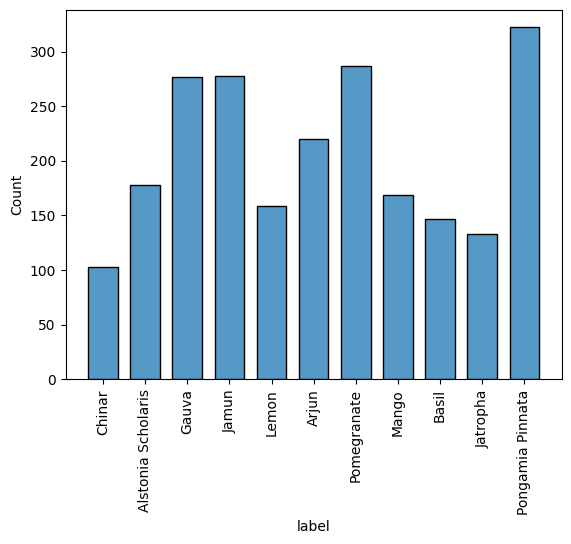

In [7]:
class_dist = sns.histplot(df, x="label", shrink = 0.7)
class_dist.set_xticklabels(class_dist.get_xticklabels(), rotation=90)

In [8]:
#build spark session
spark = SparkSession.builder.appName("LeavesSimilarity").master("local[*]").getOrCreate()
sc = spark.sparkContext

In [9]:
#create an rdd with paths of images
leaves_path_rdd = sc.parallelize(img_paths)

##2)Feature Extraction
For each image in our RDD we'll perform ORB (Oriented FAST and Rotated BRIEF) , it is a feature detection and description algorithm commonly used in computer vision tasks such as object recognition, image stitching, and visual tracking. We'll obtain keypoints for the features and a correspondent descriptor

In [10]:
def feature_extractor(filepath: str)-> List[Tuple[Tuple[float, float], np.ndarray]]:
  img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
  #initialize ORB
  orb = cv2.ORB_create()
  #detect keypoints and descriptors
  keypoints, descriptors = orb.detectAndCompute(img, None)
  rdd_element = []
  for item in zip(keypoints,descriptors):
    keypoint = item[0]
    descriptor = item[1]
    #converting the keypoint as a tuple since the original object is not serializable
    image_keypoint = (
            (
                keypoint.pt,
                keypoint.size,
                keypoint.angle,
                keypoint.response,
                keypoint.octave,
                keypoint.class_id,
            ),
            descriptor,
        )
    rdd_element.append(image_keypoint)
  return rdd_element

In [11]:
#map filepaths to feature vectors
features_rdd = leaves_path_rdd.map(lambda file: (feature_extractor(file), file))

##3) Generate Hash functions
In this section we'll proceed to generate hash function that will be used to obtain the signature matrix of the descriptors for each image in the rdd: starting from finding the highest value that the list of desriptors can assume we generate a given number of hash functions with this pattern


```
(a * x + b) % max_element_value
```

Where x is the input value, a and b are both random numbers between 1 and max_element_value


In [12]:
def find_max_descriptor_value(rdd_element):
  # we ignore the filepath since we want to find the highest element value in the features
  feature_vector, _ = rdd_element
  max_value = 0
  #we ignore keypoints
  for _, descriptor in feature_vector:
    internal_max = np.max(descriptor)
    if internal_max > max_value:
      max_value = internal_max
  return max_value

In [13]:
max_element_values_rdd = features_rdd.map(find_max_descriptor_value)

In [14]:
max_element_value = max_element_values_rdd.reduce(max)

In [15]:
def generate_hash_functions(num_hash_functions, max_element_value):
  # Generate a set of hash functions
  hash_functions = []
  for _ in range(num_hash_functions):
    a = np.random.randint(1, max_element_value)
    b = np.random.randint(1, max_element_value)
    hash_functions.append(lambda x: np.mod(a * x + b, max_element_value))
  return hash_functions

In [31]:
#we set hash functions equal to the number of classes
num_hash_functions = 11
num_bands = 11
band_size = int(len(img_paths)/num_hash_functions)

In [17]:
hash_functions = generate_hash_functions(num_hash_functions,max_element_value)

##4)Signature Matrix
In this section we'll compose our signature matrix, first we're going to apply our hash functions to all the image's descriptors, then we'll fill in the matrix with the unique signatures present in the whole rdd to save space and insert the image signatures for each row

In [18]:
def compute_signature(element, hash_functions):
  (keypoints, filepath) = element
  signature = []
  num_hash_functions = len(hash_functions)
  for j,(keypoint,descriptor) in enumerate(keypoints):
    #we take the descriptors array inside the keypoint tuple
    hash_values = hash_functions[j % num_hash_functions](descriptor)
    signature.append(np.min(hash_values))
  return (signature, filepath)

In [19]:
signatures_rdd = features_rdd.map(lambda x: compute_signature(x,hash_functions))

In [20]:
def explode_list(signatures):
  for k in signatures:
    yield k

In [21]:
unique_signatures = signatures_rdd.flatMap(lambda x:explode_list(x[0])).distinct().collect()

In [27]:
def fill_signature_matrix(data_tuple, unique_signatures):
  hash_signatures, file_path = data_tuple

  num_signatures = len(unique_signatures)
  signature_vector = np.zeros(num_signatures, dtype=int)

  signature_indices = np.searchsorted(unique_signatures, hash_signatures)
  signature_vector[signature_indices] = 1

  return file_path, signature_vector

In [28]:
signature_matrix_rdd = signatures_rdd.map(lambda x: fill_signature_matrix(x, unique_signatures))

In [24]:
signature_matrix_rdd.take(1)

[('./resized/Chinar healthy (P11a)/0011_0002.JPG',
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
         1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))]

## 5) Candidate Pairs
We generate the candidate pairs among the bands in the signature matrix and compute jaccard similarity between signature vectors

In [45]:
def jaccard_similarity(signvec_a,signvec_b):
  intersection = sum([1 for a,b in zip(signvec_a, signvec_b) if a == b and a == 1])
  union = sum([1 for a,b in zip(signvec_a, signvec_b) if a == 1 or b == 1])
  try:
    similarity = intersection / union
    return similarity
  except ZeroDivisionError:
    return 0

In [46]:
def candidate_pairs(pair):
  pairs = []
  for i in range(len(pair)):
    for j in range(i+1, len(pair)):
      pairs.append((pair[i][0],pair[j][0], jaccard_similarity(pair[i][1],pair[j][1])))
  return pairs

In [47]:
candidate_pairs_rdd = signature_matrix_rdd.flatMap(lambda x: [(i, (x[0], x[1][i * band_size: (i + 1) * band_size])) for i in range(num_bands)]) \
                                          .groupByKey()\
                                          .flatMap(lambda x: candidate_pairs(list(x[1])))

In [48]:
candidate_pairs_rdd.take(3)

[('./resized/Chinar healthy (P11a)/0011_0002.JPG',
  './resized/Chinar healthy (P11a)/0011_0023.JPG',
  0.75),
 ('./resized/Chinar healthy (P11a)/0011_0002.JPG',
  './resized/Chinar healthy (P11a)/0011_0100.JPG',
  0.7916666666666666),
 ('./resized/Chinar healthy (P11a)/0011_0002.JPG',
  './resized/Chinar healthy (P11a)/0011_0041.JPG',
  0.7391304347826086)]

In [49]:
best_pairs = candidate_pairs_rdd.filter(lambda x: x[2]>0.7)

In [55]:
worst_pairs = candidate_pairs_rdd.filter(lambda x: x[2]<0.40)

In [51]:
best_pairs.take(2)

[('./resized/Chinar healthy (P11a)/0011_0002.JPG',
  './resized/Chinar healthy (P11a)/0011_0023.JPG',
  0.75),
 ('./resized/Chinar healthy (P11a)/0011_0002.JPG',
  './resized/Chinar healthy (P11a)/0011_0100.JPG',
  0.7916666666666666)]

##6)Results


In [52]:
best_similarity_list = best_pairs.map(lambda x: x[2]).collect()
n_images = math.ceil(np.sqrt(best_pairs.count()))
best_similarity_matrix = np.zeros((n_images, n_images))
for i, sim in enumerate(best_similarity_list):
  row = i // n_images
  col = i % n_images
  best_similarity_matrix[row, col] = sim
  best_similarity_matrix[col, row] = sim

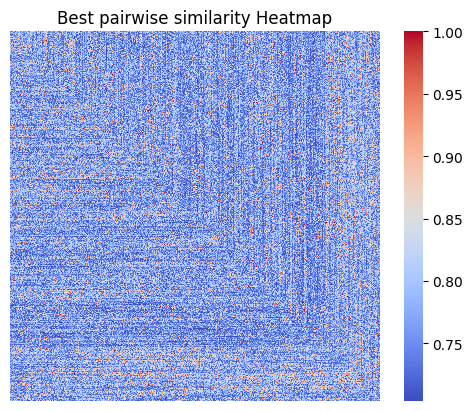

In [53]:
min_sim = min(best_similarity_list)
max_sim = max(best_similarity_list)
plt.figure()
sns.heatmap(best_similarity_matrix, annot=False, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False, vmin=min_sim, vmax=max_sim)
plt.title('Best pairwise similarity Heatmap')
plt.show()

In [56]:
worst_similarity_list = worst_pairs.map(lambda x: x[2]).collect()
n_images = math.ceil(np.sqrt(worst_pairs.count()))
worst_similarity_matrix = np.zeros((n_images, n_images))
for i, sim in enumerate(worst_similarity_list):
  row = i // n_images
  col = i % n_images
  worst_similarity_matrix[row, col] = sim
  worst_similarity_matrix[col, row] = sim

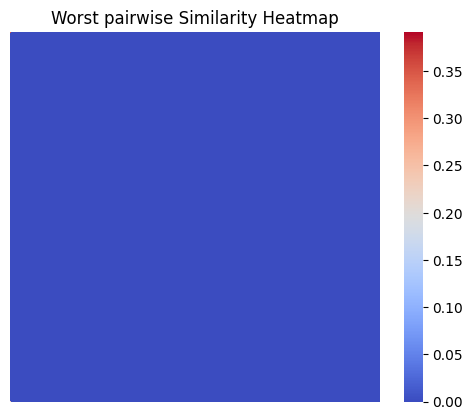

In [57]:
min_sim = min(worst_similarity_list)
max_sim = max(worst_similarity_list)
plt.figure()
sns.heatmap(worst_similarity_matrix, annot=False, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False, vmin=min_sim, vmax=max_sim)
plt.title('Worst pairwise Similarity Heatmap')
plt.show()

In [61]:
similarity_list = candidate_pairs_rdd.map(lambda x: x[2]).collect()
n_images = math.ceil(np.sqrt(candidate_pairs_rdd.count()))
similarity_matrix = np.zeros((n_images, n_images))
for i, sim in enumerate(similarity_list):
  row = i // n_images
  col = i % n_images
  similarity_matrix[row, col] = sim
  similarity_matrix[col, row] = sim

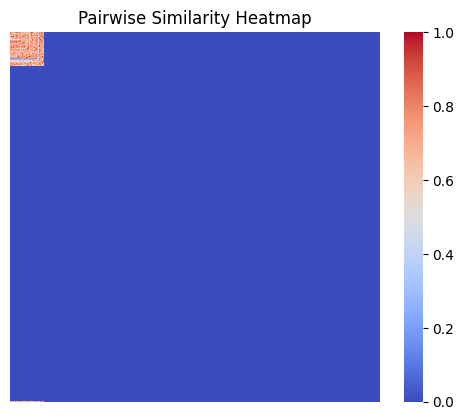

In [62]:
plt.figure()
sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False)
plt.title('Pairwise Similarity Heatmap')
plt.show()

Results within plant types

In [63]:
def simiilarity_within_plants_heatmap(similarities_rdd, plant_type):
  plant_sim_rdd = similarities_rdd.filter(lambda x: plant_type in x[0] and plant_type in x[1])
  similarity_list = plant_sim_rdd.map(lambda x: x[2]).collect()
  n_images = math.ceil(np.sqrt(len(similarity_list)))
  similarity_matrix = np.zeros((n_images, n_images))
  for i, sim in enumerate(similarity_list):
    row = i // n_images
    col = i % n_images
    similarity_matrix[row, col] = sim
    similarity_matrix[col, row] = sim
  return similarity_matrix


In [64]:
names = list(set(plant_name))

In [65]:
heatmap_list = [simiilarity_within_plants_heatmap(candidate_pairs_rdd, name) for name in names]

In [66]:
#we want all the heatmaps to be on the same scale (some of them have 0.8 as minimum, others 0.7 and so on)
min_sim = worst_pairs.min(lambda x: x[2])[2]

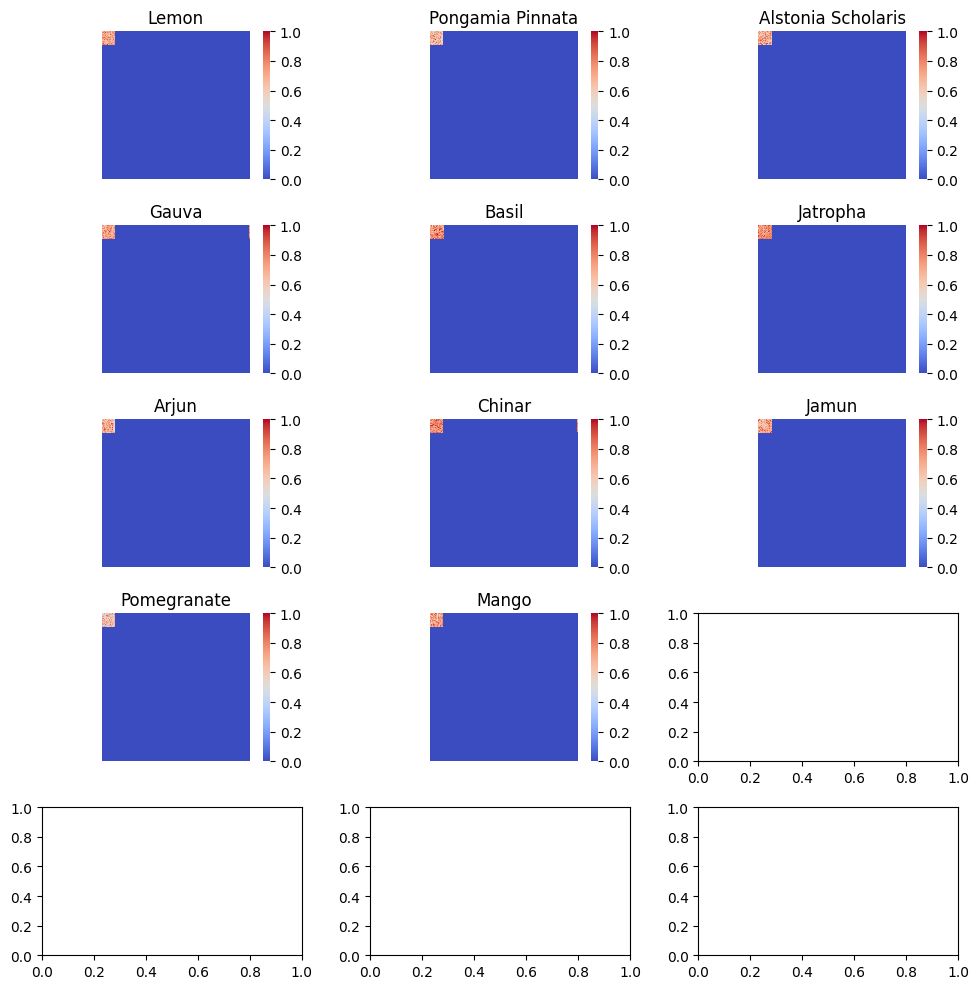

In [67]:
num_rows = int(len(heatmap_list) / 3) + len(heatmap_list) % 3
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))

# Plot each heatmap in a separate subplot
for i, ax in enumerate(axes.flat):
  if i < len(heatmap_list):
    sns.heatmap(heatmap_list[i], annot=False, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False, vmin=min_sim, vmax=1.0, ax=ax)
    ax.set_title(names[i])

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

###Metrics
By setting a similarity threshold we'll measure LSH performances by setting to true the pairs with similarity over this treshold. To check with real labels i considered a pair to be similar if the two images belong to the same plant type and that information is collected by taking the folder from the image's filepath

In [68]:
def pred_true(pair, threshold):
  plant_a = pair[0].split("healthy")[0].strip()
  plant_b = pair[1].split("healthy")[0].strip()
  similarity = pair[2]
  true_pair = None
  prediction = None
  if plant_a == plant_b:
    true_pair = 1
  else:
    true_pair = 0
  if similarity > threshold:
    prediction = 1
  else:
    prediction = 0
  return true_pair, prediction

In [69]:
actual_pred_rdd = candidate_pairs_rdd.map(lambda x: pred_true(x, 0.7))

In [70]:
tp = actual_pred_rdd.filter(lambda x: x[0] == 1 and x[1] == 1).count()
fp = actual_pred_rdd.filter(lambda x: x[0] == 1 and x[1] == 0).count()
fn = actual_pred_rdd.filter(lambda x: x[0] == 0 and x[1] == 1).count()

In [71]:
precision = tp / (tp +fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

In [72]:
print("Precision:"+str(round(precision,2)))
print("Recall:"+str(round(recall,2)))
print("F1-score:"+str(round(f1,3)))

Precision:0.04
Recall:0.11
F1-score:0.063
